In [40]:
from IPython.display import clear_output
!cp kaggle.json ~./kaggle
!pip install opendatasets
from IPython.display import clear_output
!cp kaggle.json ~./kaggle
!pip install opendatasets
clear_output()
import opendatasets as od
od.download("https://www.kaggle.com/datasets/lama2134/clahe-and-histogram-dataset")
#od.download("https://www.kaggle.com/datasets/lama2134/preprocess-dataset")
#od.download("https://www.kaggle.com/datasets/asmagamal2/ocular-diseases-asma")
# 0ba003432dd7ab5c0695b0db0aef7cf1
# lama2134

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lama2134
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/lama2134/clahe-and-histogram-dataset


100%|██████████| 2.11G/2.11G [01:49<00:00, 20.6MB/s]


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Model traning on the original CFP dataset


In [ ]:
import keras_tuner as kt
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Paths
dataset_dir = '/content/ocular-diseases-asma/Eye-diseasesasma'
train_dir = '/content/split_data2/train2'
val_dir = '/content/split_data2/val2'
test_dir = '/content/split_data2/test2'

# Split Dataset
def split_dataset(dataset_dir, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)
            val_split = val_size / (1 - test_size)
            train_files, val_files = train_test_split(train_val_files, test_size=val_split, random_state=42)


            for file in train_files:
                target_dir = os.path.join(train_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)

            for file in val_files:
                target_dir = os.path.join(val_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)

            for file in test_files:
                target_dir = os.path.join(test_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)

    print(f"Training samples: {sum([len(files) for _, _, files in os.walk(train_dir)])}")
    print(f"Validation samples: {sum([len(files) for _, _, files in os.walk(val_dir)])}")
    print(f"Testing samples: {sum([len(files) for _, _, files in os.walk(test_dir)])}")

split_dataset(dataset_dir, train_dir, val_dir, test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)


val_datagen = ImageDataGenerator(
    rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

test_datagen = ImageDataGenerator(
    rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False

)


Training samples: 7588
Validation samples: 2531
Testing samples: 2532
Found 7588 images belonging to 4 classes.
Found 2531 images belonging to 4 classes.
Found 2532 images belonging to 4 classes.


**Model**

*   load the model that built it in the Model traning on the clahe dataset section




In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the saved model
loaded_model = load_model('/content/CFP_vgg19_model.h5')


# Set the last 10 layers to trainable
for layer in loaded_model.layers[-10:]:
    layer.trainable = True

# Compile the model with new settings
loaded_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Save the updated model
loaded_model.save('/content/CFP_vgg19_model.keras')

print("Model settings updated and saved successfully.")


Model settings updated and saved successfully.


In [6]:
loaded_model = load_model('/content/CFP_vgg19_model.keras')
loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 82 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 384)                 │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,540 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,038,094 (232.84 MB)

 Trainable params: 20,345,988 (77.61 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 40,691,978 (155.23 MB)

In [7]:
unfrozen_layers = sum(1 for layer in loaded_model.layers if layer.trainable)
print(f"Number of unfrozen layers: {unfrozen_layers}")


Number of unfrozen layers: 8


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = loaded_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,
    callbacks=[early_stopping]
)


Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 215s 889ms/step - accuracy: 0.9483 - loss: 0.5105 - val_accuracy: 0.9395 - val_loss: 0.5313
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 213s 875ms/step - accuracy: 0.9556 - loss: 0.4900 - val_accuracy: 0.9143 - val_loss: 0.5715
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 211s 871ms/step - accuracy: 0.9572 - loss: 0.4680 - val_accuracy: 0.8957 - val_loss: 0.6098


In [14]:
val_loss, val_accuracy = loaded_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.9371 - loss: 0.5370
Validation Loss: 0.5313
Validation Accuracy: 0.9395
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - accuracy: 0.9407 - loss: 0.5167
Test Loss: 0.5584
Test Accuracy: 0.9230


In [15]:
import numpy as np

# Predict probabilities for a single image or a batch of images
img, label = next(test_generator)

predictions = loaded_model.predict(img)


percentages = predictions * 100


predicted_classes = np.argmax(predictions, axis=1)


class_labels = {v: k for k, v in test_generator.class_indices.items()}

# Display results for each image in the batch
for i in range(len(img)):
    print(f"Image {i + 1}:")
    print("Percentages per class:")
    for j, class_name in enumerate(class_labels.values()):
        print(f"  {class_name}: {percentages[i][j]:.2f}%")
    print(f"Predicted Class: {class_labels[predicted_classes[i]]}")
    print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image 1:
Percentages per class:
  Normal: 96.39%
  cataract: 0.85%
  diabetic_retinopathy: 0.20%
  glaucoma: 2.55%
Predicted Class: Normal
------------------------------
Image 2:
Percentages per class:
  Normal: 99.68%
  cataract: 0.02%
  diabetic_retinopathy: 0.19%
  glaucoma: 0.12%
Predicted Class: Normal
------------------------------
Image 3:
Percentages per class:
  Normal: 99.15%
  cataract: 0.24%
  diabetic_retinopathy: 0.13%
  glaucoma: 0.47%
Predicted Class: Normal
------------------------------
Image 4:
Percentages per class:
  Normal: 42.87%
  cataract: 54.56%
  diabetic_retinopathy: 0.26%
  glaucoma: 2.31%
Predicted Class: cataract
------------------------------
Image 5:
Percentages per class:
  Normal: 99.07%
  cataract: 0.25%
  diabetic_retinopathy: 0.30%
  glaucoma: 0.38%
Predicted Class: Normal
------------------------------
Image 6:
Percentages per class:
  Normal: 99.34%
  cataract: 0.04%
  diabetic_retinopathy: 0.12%
  glaucoma: 

** Visualizing the matrices**

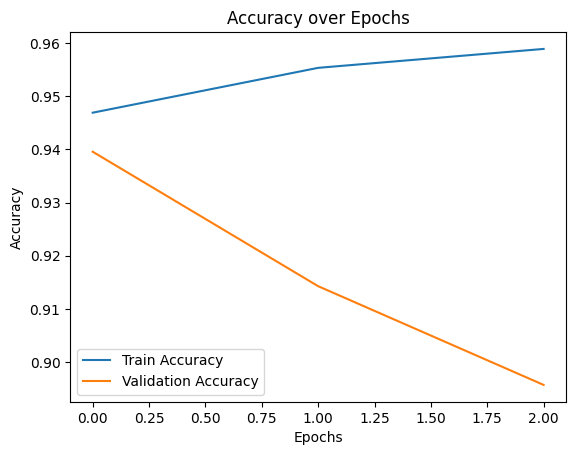

In [16]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

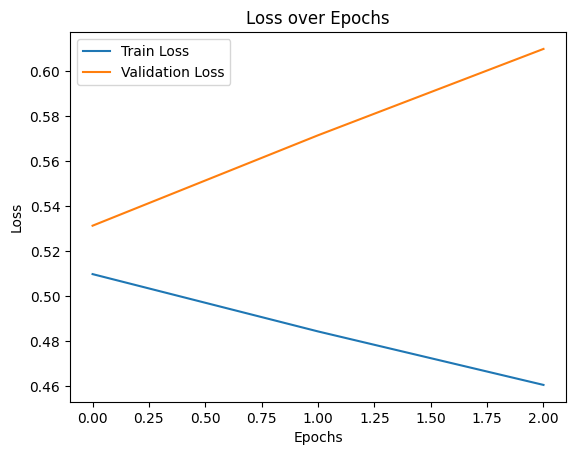

In [17]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 371ms/step
Classification Report:
                      precision    recall  f1-score   support

              Normal       0.84      0.95      0.89       645
            cataract       0.95      0.95      0.95       623
diabetic_retinopathy       0.97      0.95      0.96       659
            glaucoma       0.95      0.84      0.89       605

            accuracy                           0.92      2532
           macro avg       0.93      0.92      0.92      2532
        weighted avg       0.93      0.92      0.92      2532



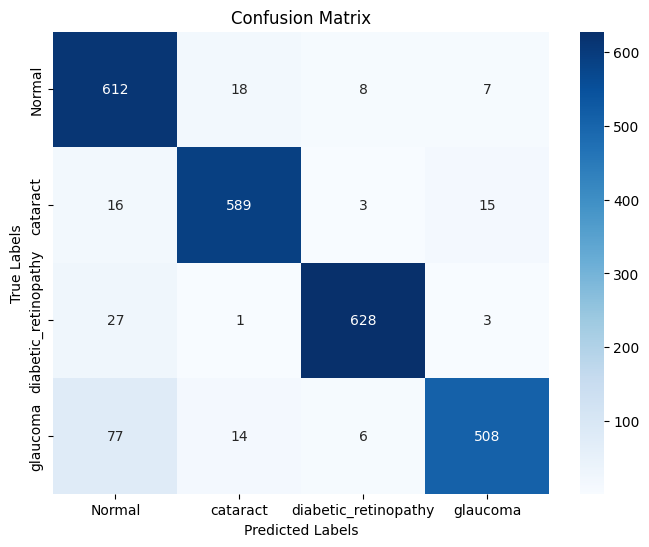

In [18]:
# Classification Report and Confusion Matrix
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

ROC-AUC Scores:
Normal: 0.9873
cataract: 0.9946
diabetic_retinopathy: 0.9985
glaucoma: 0.9857


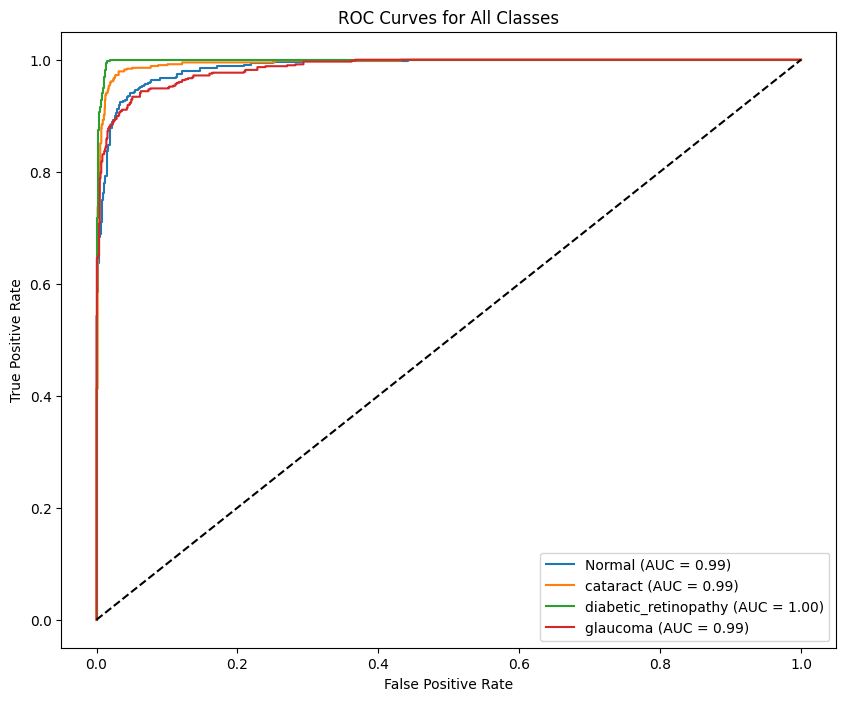

In [19]:
# ROC-AUC
true_labels_one_hot = np.zeros((len(true_classes), len(class_labels)))
true_labels_one_hot[np.arange(len(true_classes)), true_classes] = 1

roc_auc_scores = {}
for i, class_name in enumerate(class_labels):
    roc_auc_scores[class_name] = roc_auc_score(true_labels_one_hot[:, i], predictions[:, i])

print("ROC-AUC Scores:")
for class_name, score in roc_auc_scores.items():
    print(f"{class_name}: {score:.4f}")

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_scores[class_name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for All Classes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

#  Model traning on the clahe dataset



In [29]:
dataset_dir = '/content/preprocess-dataset'
train_dir = '/content/split_data3/train3'
val_dir = '/content/split_data3/val3'
test_dir = '/content/split_data3/test3'

# Split the Dataset
def split_dataset(dataset_dir, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2):


    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):

            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

            # Split into test set (20%) and remaining (80%)
            train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)


            val_split = val_size / (1 - test_size)
            train_files, val_files = train_test_split(train_val_files, test_size=val_split, random_state=42)


            for file in train_files:
                target_dir = os.path.join(train_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)


            for file in val_files:
                target_dir = os.path.join(val_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)


            for file in test_files:
                target_dir = os.path.join(test_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)

    print("Dataset successfully split into training, validation, and testing subsets.")

split_dataset(dataset_dir, train_dir, val_dir, test_dir)

Dataset successfully split into training, validation, and testing subsets.


In [30]:
# Function to count files in a directory
def count_files(directory):
    total_files = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            total_files += len(os.listdir(class_path))
    return total_files


train_count = count_files(train_dir)
val_count = count_files(val_dir)
test_count = count_files(test_dir)
total_count = train_count + val_count + test_count

# Print the proportions
print(f"Training: {train_count} ({train_count / total_count:.2%})")
print(f"Validation: {val_count} ({val_count / total_count:.2%})")
print(f"Testing: {test_count} ({test_count / total_count:.2%})")

Training: 7588 (59.98%)
Validation: 2531 (20.01%)
Testing: 2532 (20.01%)


In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


val_datagen = ImageDataGenerator(
    rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(
    rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 7588 images belonging to 4 classes.
Found 2531 images belonging to 4 classes.
Found 2532 images belonging to 4 classes.


Model

*   build the model




In [32]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
import tensorflow as tf

def model_builder(hp):
    # Initialize the base model
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    # Build the model
    model = models.Sequential([
        base_model,
        layers.Conv2D(
            hp.Int('filters1', min_value=64, max_value=96, step=32),
            kernel_size=(3, 3),
            activation='relu',
            padding='same'
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(
            hp.Int('units', min_value=256, max_value=384, step=128),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ),
        layers.Dropout(0.1),
        layers.Dense(4, activation='softmax')  # Output layer for 4 classes
    ])

    # Compile the model
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4]))
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 2:
        return lr * 0.1
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# Initialize the tuner with fewer trials
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,  # Fewer trials
    directory='my_dir',
    project_name='vgg19_tuning_fast'
)

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run the tuner with a subset of training data
small_train_generator = train_generator
small_val_generator = validation_generator

# Run the tuner
tuner.search(
    small_train_generator,
    validation_data=small_val_generator,
    epochs=5,  # Fewer epochs per trial
    callbacks=[early_stopping, lr_callback]
)

# Train the best model
best_model = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])

NameError: name 'kt' is not defined

In [ ]:
# Save the trained model
best_model.save('/content/CFP_vgg19_model.h5')

In [33]:
# use the loded model
history = loaded_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,
    callbacks=[early_stopping]
)


Epoch 1/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 190s 777ms/step - accuracy: 0.9303 - loss: 0.5328 - val_accuracy: 0.8771 - val_loss: 0.6865
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 188s 777ms/step - accuracy: 0.9200 - loss: 0.5534 - val_accuracy: 0.8763 - val_loss: 0.6517
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 195s 800ms/step - accuracy: 0.9616 - loss: 0.4419 - val_accuracy: 0.9083 - val_loss: 0.5717


In [34]:
val_loss, val_accuracy = loaded_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.8895 - loss: 0.6473
Validation Loss: 0.6865
Validation Accuracy: 0.8771
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.9140 - loss: 0.5725
Test Loss: 0.7036
Test Accuracy: 0.8677


In [35]:
import numpy as np


img, label = next(test_generator)

predictions = loaded_model.predict(img)  # Predict probabilities

# Convert probabilities to percentages
percentages = predictions * 100


predicted_classes = np.argmax(predictions, axis=1)


class_labels = {v: k for k, v in test_generator.class_indices.items()}


for i in range(len(img)):
    print(f"Image {i + 1}:")
    print("Percentages per class:")
    for j, class_name in enumerate(class_labels.values()):
        print(f"  {class_name}: {percentages[i][j]:.2f}%")
    print(f"Predicted Class: {class_labels[predicted_classes[i]]}")
    print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image 1:
Percentages per class:
  Normal: 82.81%
  cataract: 0.05%
  diabetic_retinopathy: 12.50%
  glaucoma: 4.64%
Predicted Class: Normal
------------------------------
Image 2:
Percentages per class:
  Normal: 94.18%
  cataract: 0.03%
  diabetic_retinopathy: 0.97%
  glaucoma: 4.82%
Predicted Class: Normal
------------------------------
Image 3:
Percentages per class:
  Normal: 96.96%
  cataract: 0.00%
  diabetic_retinopathy: 3.02%
  glaucoma: 0.02%
Predicted Class: Normal
------------------------------
Image 4:
Percentages per class:
  Normal: 99.60%
  cataract: 0.00%
  diabetic_retinopathy: 0.16%
  glaucoma: 0.24%
Predicted Class: Normal
------------------------------
Image 5:
Percentages per class:
  Normal: 47.42%
  cataract: 48.40%
  diabetic_retinopathy: 0.52%
  glaucoma: 3.67%
Predicted Class: cataract
------------------------------
Image 6:
Percentages per class:
  Normal: 99.28%
  cataract: 0.01%
  diabetic_retinopathy: 0.68%
  glaucoma:

Visualizing the matrices

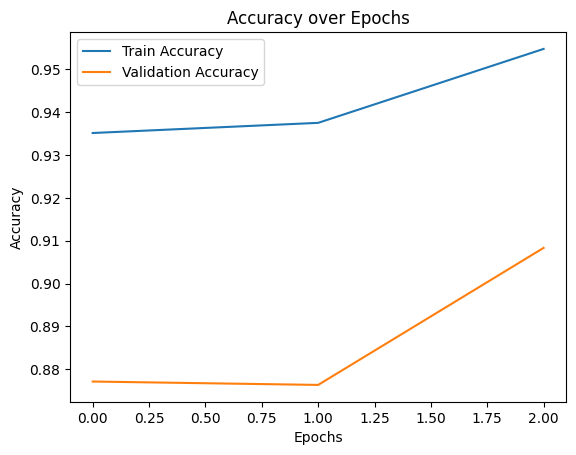

In [36]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

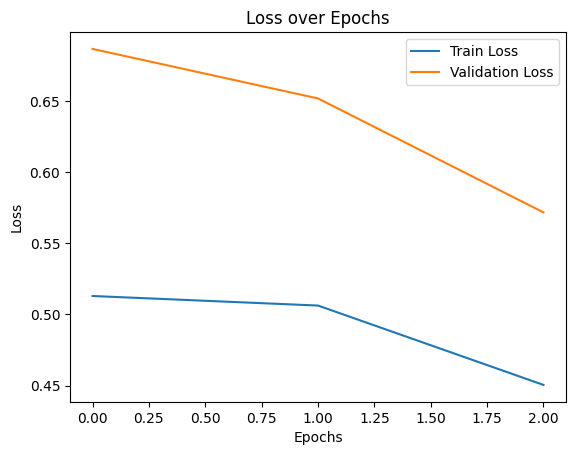

In [37]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step
Classification Report:
                      precision    recall  f1-score   support

              Normal       0.72      0.97      0.83       645
            cataract       0.97      0.81      0.89       623
diabetic_retinopathy       0.97      0.92      0.94       659
            glaucoma       0.88      0.77      0.82       605

            accuracy                           0.87      2532
           macro avg       0.89      0.87      0.87      2532
        weighted avg       0.89      0.87      0.87      2532



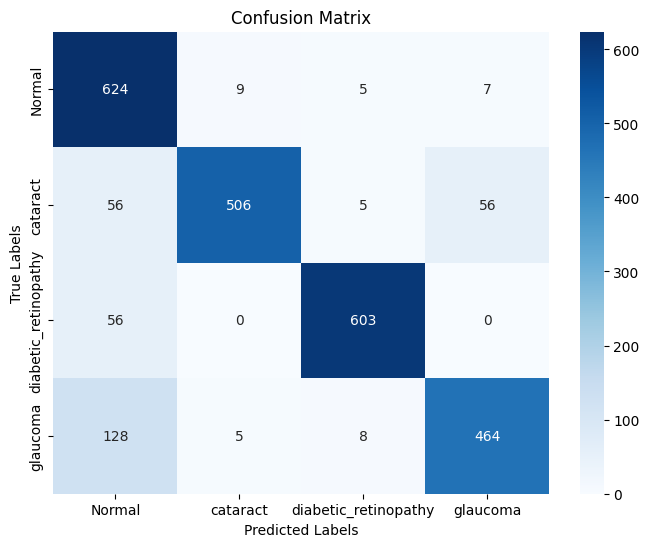

In [38]:
# Classification Report and Confusion Matrix
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

ROC-AUC Scores:
Normal: 0.9838
cataract: 0.9921
diabetic_retinopathy: 0.9973
glaucoma: 0.9646


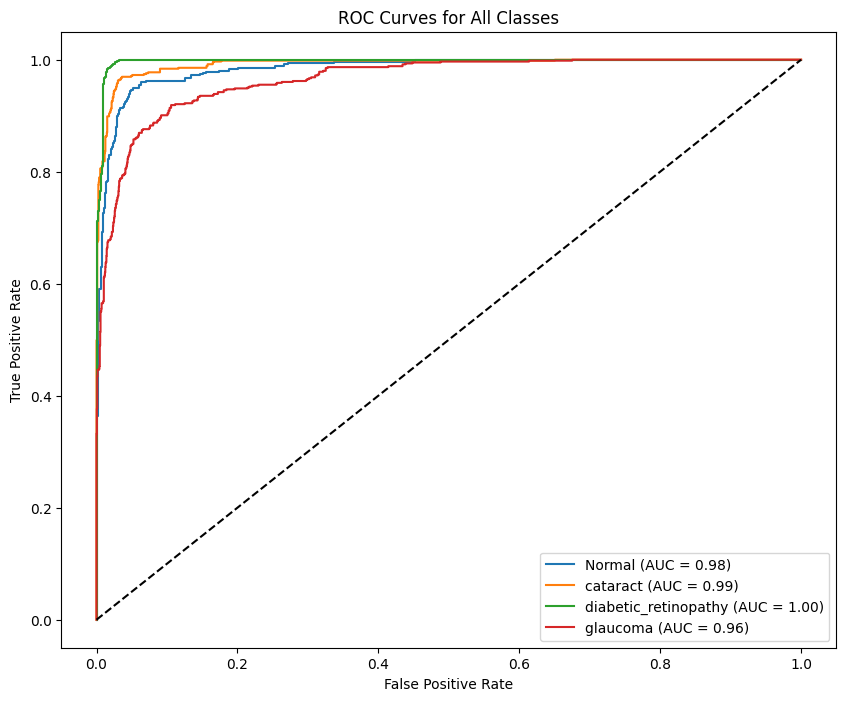

In [39]:
# ROC-AUC
true_labels_one_hot = np.zeros((len(true_classes), len(class_labels)))
true_labels_one_hot[np.arange(len(true_classes)), true_classes] = 1

roc_auc_scores = {}
for i, class_name in enumerate(class_labels):
    roc_auc_scores[class_name] = roc_auc_score(true_labels_one_hot[:, i], predictions[:, i])

print("ROC-AUC Scores:")
for class_name, score in roc_auc_scores.items():
    print(f"{class_name}: {score:.4f}")

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_scores[class_name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for All Classes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Model traning on the clahe-and-histogram-dataset

In [41]:

dataset_dir = '/content/clahe-and-histogram-dataset/H+C_dataset'
train_dir = '/content/split_data4/train4'
val_dir = '/content/split_data4/val4'
test_dir = '/content/split_data4/test4'

# Split the Dataset
def split_dataset(dataset_dir, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2):

    # Ensure directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):

            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

            # Split into test set (20%) and remaining (80%)
            train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)


            val_split = val_size / (1 - test_size)
            train_files, val_files = train_test_split(train_val_files, test_size=val_split, random_state=42)


            for file in train_files:
                target_dir = os.path.join(train_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)


            for file in val_files:
                target_dir = os.path.join(val_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)

         \
            for file in test_files:
                target_dir = os.path.join(test_dir, class_name)
                os.makedirs(target_dir, exist_ok=True)
                shutil.copy(file, target_dir)

    print("Dataset successfully split into training, validation, and testing subsets.")

split_dataset(dataset_dir, train_dir, val_dir, test_dir)

Dataset successfully split into training, validation, and testing subsets.


In [42]:
# Function to count files in a directory
def count_files(directory):
    total_files = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            total_files += len(os.listdir(class_path))
    return total_files


train_count = count_files(train_dir)
val_count = count_files(val_dir)
test_count = count_files(test_dir)
total_count = train_count + val_count + test_count


print(f"Training: {train_count} ({train_count / total_count:.2%})")
print(f"Validation: {val_count} ({val_count / total_count:.2%})")
print(f"Testing: {test_count} ({test_count / total_count:.2%})")

Training: 7588 (59.98%)
Validation: 2531 (20.01%)
Testing: 2532 (20.01%)


In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


val_datagen = ImageDataGenerator(
    rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(
    rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False

)

Found 7588 images belonging to 4 classes.
Found 2531 images belonging to 4 classes.
Found 2532 images belonging to 4 classes.


Model

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = loaded_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,
    callbacks=[early_stopping]
)



Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


238/238 ━━━━━━━━━━━━━━━━━━━━ 239s 982ms/step - accuracy: 0.8365 - loss: 0.7741 - val_accuracy: 0.8566 - val_loss: 0.7128
Epoch 2/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 228s 928ms/step - accuracy: 0.9225 - loss: 0.5371 - val_accuracy: 0.7780 - val_loss: 0.9542
Epoch 3/3
238/238 ━━━━━━━━━━━━━━━━━━━━ 243s 854ms/step - accuracy: 0.9430 - loss: 0.4901 - val_accuracy: 0.8712 - val_loss: 0.6529


In [46]:
val_loss, val_accuracy = loaded_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.8607 - loss: 0.6704
Validation Loss: 0.6529
Validation Accuracy: 0.8712
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.9354 - loss: 0.4833
Test Loss: 0.6798
Test Accuracy: 0.8606


In [ ]:
import numpy as np


img, label = next(test_generator)

predictions = loaded_model.predict(img)


percentages = predictions * 100


predicted_classes = np.argmax(predictions, axis=1)


class_labels = {v: k for k, v in test_generator.class_indices.items()}


for i in range(len(img)):
    print(f"Image {i + 1}:")
    print("Percentages per class:")
    for j, class_name in enumerate(class_labels.values()):
        print(f"  {class_name}: {percentages[i][j]:.2f}%")
    print(f"Predicted Class: {class_labels[predicted_classes[i]]}")
    print("-" * 30)

Visualizing the matrices

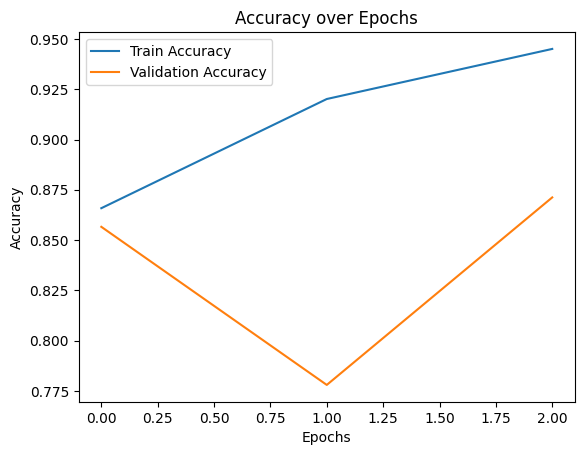

In [47]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

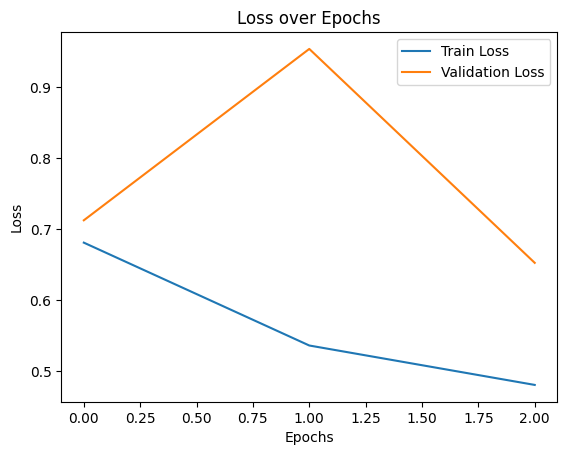

In [48]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step
Classification Report:
                      precision    recall  f1-score   support

              Normal       0.70      0.97      0.81       645
            cataract       0.90      0.97      0.94       623
diabetic_retinopathy       0.97      0.82      0.89       659
            glaucoma       0.99      0.67      0.80       605

            accuracy                           0.86      2532
           macro avg       0.89      0.86      0.86      2532
        weighted avg       0.89      0.86      0.86      2532



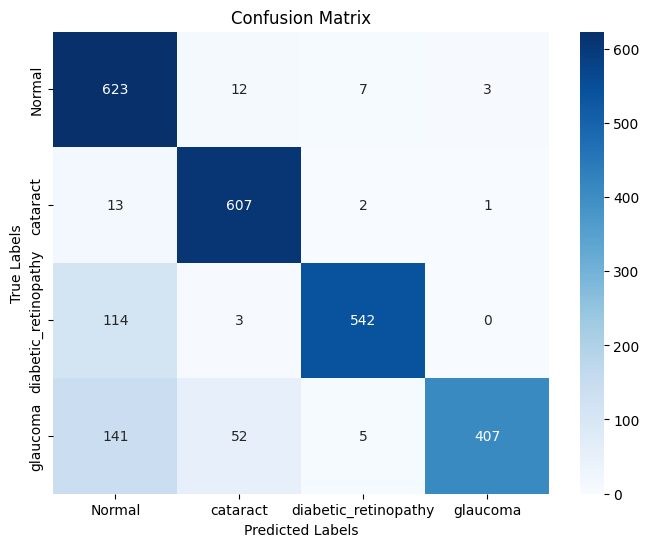

In [49]:
# Confusion Matrix
predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

ROC-AUC Scores:
Normal: 0.9811
cataract: 0.9940
diabetic_retinopathy: 0.9951
glaucoma: 0.9826


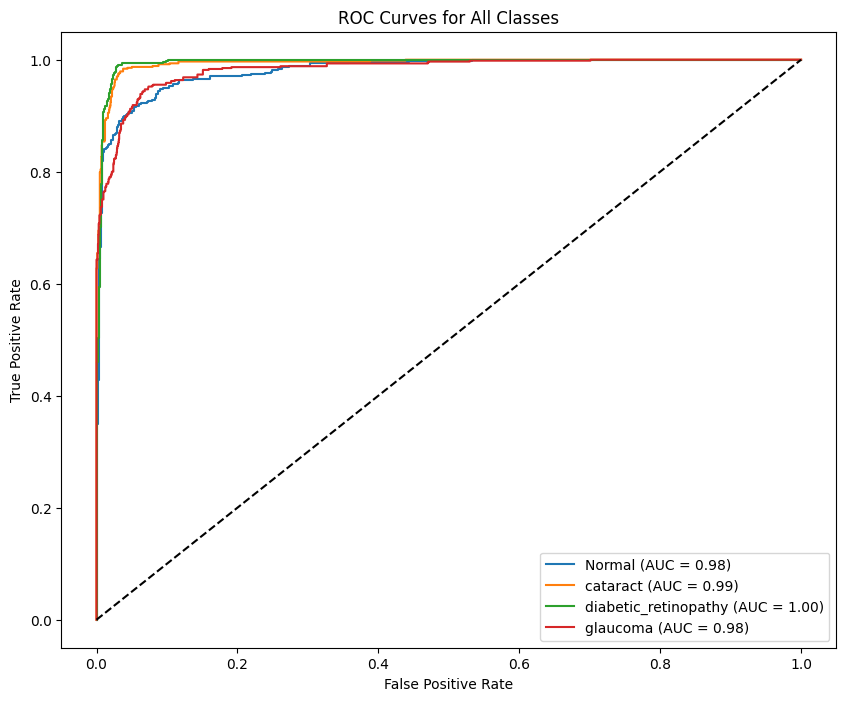

In [50]:
# ROC-AUC
true_labels_one_hot = np.zeros((len(true_classes), len(class_labels)))
true_labels_one_hot[np.arange(len(true_classes)), true_classes] = 1

roc_auc_scores = {}
for i, class_name in enumerate(class_labels):
    roc_auc_scores[class_name] = roc_auc_score(true_labels_one_hot[:, i], predictions[:, i])

print("ROC-AUC Scores:")
for class_name, score in roc_auc_scores.items():
    print(f"{class_name}: {score:.4f}")

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_scores[class_name]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for All Classes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()